# Predicting Age From X-Rays

# Goal
Develop an algorithm to determine the age of a child by utilizing x-rays of hands (pediatric hand radiographs).

In [1]:
# Common variables for all models
from keras.callbacks import EarlyStopping, ReduceLROnPlateau    

epochs = 200

batchSize = 100
imageLength = 150
imageHeight = 150

# Stop training when a monitored quantity has stopped improving after 15 epochs
earlyStop = EarlyStopping(patience=15, verbose=1)

# Reduce learning rate when a metric has stopped improving
reduceLR = ReduceLROnPlateau(factor=0.3, patience=3, cooldown=3, verbose=1)

from keras import backend as K
print('\nData format for Keras is:', K.image_data_format())

Using TensorFlow backend.



Data format for Keras is: channels_last


## Expore the dataset

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 

# CSV file contains the id, age, and gender related to each x-ray
dataset = pd.read_csv("Input/boneage-dataset.csv")

# Dropping all rows with any NA values
dataset.dropna()

print('There are %d total data samples.' % dataset.shape[0])
print('\nData type for each column is:\n',dataset.dtypes)
dataset.head()

There are 12611 total data samples.

Data type for each column is:
 id         int64
boneage    int64
male        bool
dtype: object


,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False


Max, mean, and standard deviation of bone age is 228, 127.32, and 41.18 months, respectively.
Total number of male and female is 6833 (54.18%) and 5778 (45.82%), respectively.


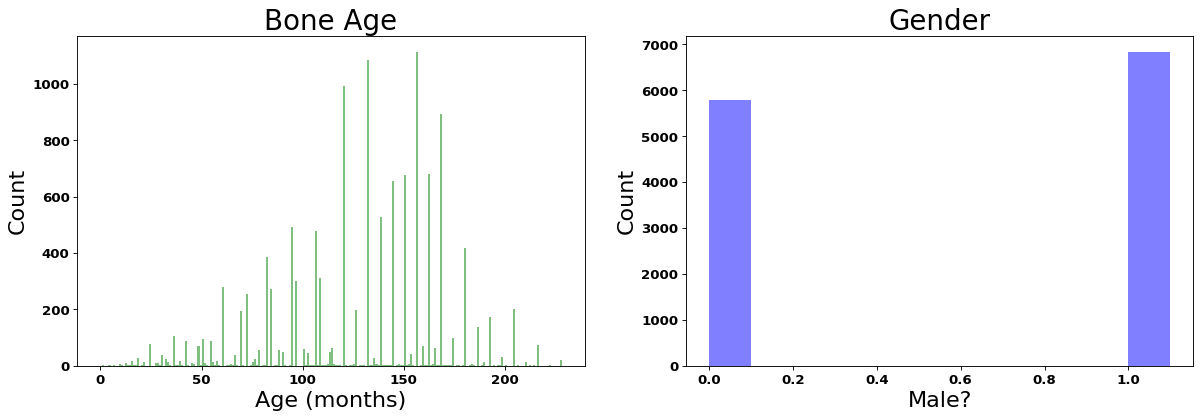

In [3]:
# Plot the total distribution for boneage and gender
import PlottingTools as pt

myFigure = plt.figure(figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k') 
myAxis1 = myFigure.add_subplot(2,2,1)
myAxis2 = myFigure.add_subplot(2,2,2)

myAxis1.hist(dataset['boneage'], 228, range = (0, 228.0), color='g', alpha=0.5)
myAxis2.hist(dataset['male'], 11, range = (0, 1.1), color='b', alpha=0.5)

#Title and stuff
pt.setTitle(myAxis1, 'Bone Age', 'Age (months)', 'Count')
pt.setTitle(myAxis2, 'Gender', 'Male?', 'Count')

#Ticks
pt.setTicks(myAxis1)
pt.setTicks(myAxis2)

myFigure.savefig('Plots/RawDistribution.pdf')

print('Max, mean, and standard deviation of bone age is %d, %.2f, and %.2f months, respectively.' 
      %(dataset['boneage'].max(), dataset['boneage'].mean(), dataset['boneage'].std()))
print('Total number of male and female is %d (%.2f%%) and %d (%.2f%%), respectively.' 
      %(dataset[dataset['male']==1].shape[0], 
        dataset[dataset['male']==1].shape[0]*100/dataset.shape[0],
        dataset[dataset['male']==0].shape[0], 
        dataset[dataset['male']==0].shape[0]*100/dataset.shape[0]))

### Connect the x-ray images to the labels

In [4]:
import os

dataset['image_path'] = dataset['id'].map(lambda x: os.path.join('Input/boneage-dataset', '{}.png'.format(x)))

if dataset['image_path'].map(os.path.exists).sum() != dataset.shape[0]:
    print('Warning!! Only', dataset['image_path'].map(os.path.exists).sum(), 
          'x-ray images found out of', dataset.shape[0], 'total! \nWill continue with reduced dataset!!')
    dataset = dataset[dataset['image_path'].map(os.path.exists)]
else:
    print('Awesome!! All',dataset['image_path'].map(os.path.exists).sum(), 
          'x-ray images found out of', dataset.shape[0], 'total!')

Awesome!! All 12611 x-ray images found out of 12611 total!


### Split data in a stratified fashion

In [5]:
# Make new colum 'boneage_category' such that each category has the same number of samples
deciles_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
deciles = dataset['boneage'].quantile(q=deciles_list)

deciles_labels =[]
for i in range(deciles.size):
    if i==deciles.size-1: continue
    deciles_labels.append(str(deciles[deciles.index[i]])+'-'+str(deciles[deciles.index[i+1]]))   
print(deciles_labels, '\n')
    
dataset['boneage_category'] = pd.qcut(dataset['boneage'], q=deciles_list, labels=deciles_labels)
print(dataset.head())

['1.0-69.0', '69.0-94.0', '94.0-106.0', '106.0-120.0', '120.0-132.0', '132.0-144.0', '144.0-156.0', '156.0-162.0', '162.0-168.0', '168.0-228.0'] 

     id  boneage   male                      image_path boneage_category
0  1377      180  False  Input/boneage-dataset/1377.png      168.0-228.0
1  1378       12  False  Input/boneage-dataset/1378.png         1.0-69.0
2  1379       94  False  Input/boneage-dataset/1379.png        69.0-94.0
3  1380      120   True  Input/boneage-dataset/1380.png      106.0-120.0
4  1381       82  False  Input/boneage-dataset/1381.png        69.0-94.0


### Split data into training, testing, and validation sets (80/10/10)

In [6]:
from sklearn.model_selection import train_test_split

dataset_train, dataset_validation = train_test_split(dataset, test_size=0.2, random_state=99, 
                                               stratify=dataset['boneage_category'])
dataset_validation, dataset_test = train_test_split(dataset_validation, test_size=0.5, random_state=99,
                                             stratify=dataset_validation['boneage_category'])
                                                                    
print("The dataset has a training set of %d examples." % len(dataset_train))
print("The dataset has a validation set of %d examples." % len(dataset_validation))
print("The dataset has a testing set of %d examples." % len(dataset_test))

The dataset has a training set of 10088 examples.
The dataset has a validation set of 1261 examples.
The dataset has a testing set of 1262 examples.


### Tools to preprocess the images for Keras

In [7]:
# Take a string-valued image path and returns 4D tensor

from keras.preprocessing import image                  
from tqdm import tqdm

def imageToTensor(imageToConvert):
    # Load the image as grayscale; w x h=imageLength x imageHeight
    img = image.load_img(imageToConvert, target_size=(imageLength, imageHeight))
    
    # Convert a PIL Image instance to a Numpy array with shape (imageLength, imageHeight, 1)
    x = image.img_to_array(img)
    
    # Convert 3D tensor to 4D tensor with shape (1, imageLength, imageHeight, 1) and return 4D tensor
    return np.expand_dims(x, axis=0)

def imagesToTensor(imagesToConvert):
    listOfTensors = [imageToTensor(imageToConvert) for imageToConvert in tqdm(imagesToConvert)]
    return np.vstack(listOfTensors)

In [8]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True          

# Convert every x-ray images to 4D tensors
X_train = imagesToTensor(dataset_train['image_path'])
X_validation = imagesToTensor(dataset_validation['image_path'])
X_test = imagesToTensor(dataset_test['image_path'])

100%|██████████| 1262/1262 [00:37<00:00, 33.70it/s]


In [9]:
# Rescale the images by dividing every pixel in every image by 255

# Rescale [0,255] --> [0,1]
X_train = X_train.astype('float32')/255
X_validation = X_validation.astype('float32')/255
X_test = X_test.astype('float32')/255

### One-hot encode the labels

In [10]:
from keras.utils import np_utils

# Bone age in the sample is from 0 to 228 months
y_train = dataset_train['boneage']
y_train = np_utils.to_categorical(y_train, 229)

y_validation = dataset_validation['boneage']
y_validation = np_utils.to_categorical(y_validation, 229)

y_test = dataset_test['boneage']
y_test = np_utils.to_categorical(y_test, 229)

print('One-hot labels:')
print(y_train[:5])

One-hot labels:
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


### Create and configure augmented image generator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Generate batches of tensor image data with real-time data augmentation
datagen_train = ImageDataGenerator(
    width_shift_range=0.15,     # Fraction of total width for random horizontal shifts
    height_shift_range=0.15,    # Fraction of total height for random vertical shifts
    rotation_range = 15,        # Degree range for random rotations
    horizontal_flip=True)      # Randomly flip images horizontally
generator_train = datagen_train.flow(X_train, y_train, batch_size=batchSize)

datagen_validation = ImageDataGenerator()
generator_validation = datagen_validation.flow(X_validation, y_validation, batch_size=batchSize)

### Visualize a single training image in detail

In [ ]:
def visualizeImage(img, ax):
    ax.imshow(np.squeeze(img), cmap='gray')
    width, height, depth = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y][0],1)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y][0]<thresh else 'black')
            
fig = plt.figure(figsize = (75,75)) 
ax = fig.add_subplot(111)
visualizeImage(X_train[2], ax)

fig.savefig('Plots/SingleTrainingImage.pdf')

### Visualize original and augmented images

In [ ]:
# Visualize the first six original and augmented training images
X_train_subset = X_train[:6]

fig = plt.figure(figsize=(20,3))
for i in range(0, len(X_train_subset)):
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train_subset[i]))
fig.suptitle('Processed training images', fontsize=20)
plt.show()
fig.savefig('Plots/ProcessedTrainingImages.pdf')

fig = plt.figure(figsize=(20,3))
for X_batch in datagen_train.flow(X_train_subset, batch_size=6):
    for i in range(6):
        ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_batch[i]), cmap='gray')
    # Need to break the loop because the generator loops indefinitely
    break 
fig.suptitle('Augmented training images', fontsize=20)
plt.show()
fig.savefig('Plots/AugmentedTrainingImages.pdf')

# Benchmark model from scratch

### Define the benchmark model architecture

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import plot_model

benchmarkModel = Sequential()

benchmarkModel.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu',input_shape=X_train[0].shape))
benchmarkModel.add(BatchNormalization())
benchmarkModel.add(MaxPooling2D(pool_size=2))
benchmarkModel.add(Dropout(0.75))

benchmarkModel.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
benchmarkModel.add(BatchNormalization())
benchmarkModel.add(MaxPooling2D(pool_size=2))
benchmarkModel.add(Dropout(0.75))

benchmarkModel.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
benchmarkModel.add(BatchNormalization())
benchmarkModel.add(MaxPooling2D(pool_size=2))
benchmarkModel.add(Dropout(0.75))

benchmarkModel.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
benchmarkModel.add(BatchNormalization())
benchmarkModel.add(MaxPooling2D(pool_size=2))
benchmarkModel.add(Dropout(0.75))

benchmarkModel.add(Flatten())         
benchmarkModel.add(Dense(500, activation='relu'))
benchmarkModel.add(BatchNormalization())
benchmarkModel.add(Dropout(0.5))

benchmarkModel.add(Dense(229, activation='softmax'))

benchmarkModel.summary()
plot_model(benchmarkModel, to_file='Plots/BenchmarkModel.pdf')

### Compile the code

In [ ]:
benchmarkModel.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.9), metrics=['accuracy'])

### Calculate the classification accuracy of the benchmark model (before training)

In [ ]:
# Evaluate the test accuracy
score = benchmarkModel.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the benchmark model (before training): %.4f%%' % accuracy)

### Train the benchmark model

In [ ]:
from keras.callbacks import ModelCheckpoint    

# Save the best model after every epoch
checkPoint = ModelCheckpoint(filepath='SavedModels/BenchmarkBest.hdf5', save_best_only=True, verbose=1)

# Fit the model on batches with real-time data augmentation:
history = benchmarkModel.fit_generator(generator_train,
                                       steps_per_epoch=X_train.shape[0] // batchSize, epochs=epochs, 
                                       validation_data=generator_validation, validation_steps=X_validation.shape[0] // batchSize,
                                       callbacks=[checkPoint, earlyStop, reduceLR], verbose=0)
# List all data in history
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Benchmark model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/BenchmarkAccuracy.pdf')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Benchmark model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/BenchmarkLoss.pdf')
plt.show()

### Calculate the classification accuracy of the benchmark model (after training)

In [ ]:
# Load the model with the best classification accuracy on the validation set
benchmarkModel.load_weights('SavedModels/BenchmarkBest.hdf5')

# Calculate the classification accuracy on the test set
score = benchmarkModel.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the benchmark model (after training): %.4f%%' % accuracy)

### Visualize the result of the benchmark model 

In [ ]:
y_pred = benchmarkModel.predict(X_test, verbose = False)

y_p = []
for y in y_pred:
    y_p.append(np.argmax(y))
y_t = []
for t in y_test:
    y_t.append(np.argmax(t))

fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(y_t, y_t, 'b-', label = 'True')
ax1.plot(y_t, y_p, 'r.', label = 'Predictions')
ax1.legend()
ax1.set_title('Benchmark model', fontsize=25)
ax1.set_xlabel('True Age (Months)', fontsize=20)
ax1.set_ylabel('Predicted Age (Months)', fontsize=20)
pt.setTicks(ax1)

fig.savefig('Plots/BenchmarkResult.pdf')

# Model based on InceptionV3

### Extract bottleneck features for training and validation dataset

In [ ]:
from keras.applications.inception_v3 import InceptionV3 

from keras.models import Model

# Load InceptionV3 model + remove final classification layers
baseModel = InceptionV3(weights='imagenet', include_top=False, input_shape=(imageLength, imageHeight, 3))

# Add a global average pooling layer
myLayers = baseModel.output
myLayers = GlobalAveragePooling2D()(myLayers)
myLayers = Dropout(0.5)(myLayers)

# A fully connected layer
myLayers = Dense(1000, activation='relu')(myLayers)
myLayers = Dropout(0.5)(myLayers)

# Output layer
predictions = Dense(229, activation='softmax')(myLayers)

# The model
InceptionV3Model = Model(inputs=baseModel.input, outputs=predictions)
plot_model(InceptionV3Model, to_file='Plots/InceptionV3BottleneckModel.pdf')

# Freeze all convolutional InceptionV3 layers
for layer in baseModel.layers:
    layer.trainable = False
    
InceptionV3Model.summary()

### Compile the code

In [ ]:
InceptionV3Model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.9), metrics=['accuracy'])

### Calculate the classification accuracy of the model (before training)

In [ ]:
# Evaluate the test accuracy
score = InceptionV3Model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the model (before training): %.4f%%' % accuracy)

### Train the model

In [ ]:
# Save the best model after every epoch
checkPoint = ModelCheckpoint(filepath='SavedModels/InceptionV3BottleneckBest.hdf5', save_best_only=True, verbose=1)

# Fit the model on batches with real-time data augmentation:
history = InceptionV3Model.fit_generator(generator_train,
                                         steps_per_epoch=X_train.shape[0] // batchSize, epochs=epochs, 
                                         validation_data=generator_validation, 
                                         validation_steps=X_validation.shape[0] // batchSize,
                                         callbacks=[checkPoint, earlyStop, reduceLR], verbose=0)

# List all data in history
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('InceptionV3 bottleneck model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/InceptionV3BottleneckAccuracy.pdf')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('InceptionV3 bottleneck model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/InceptionV3BottleneckLoss.pdf')
plt.show()

### Calculate the classification accuracy of the model (after training)

In [ ]:
# Load the model with the best classification accuracy on the validation set
InceptionV3Model.load_weights('SavedModels/InceptionV3BottleneckBest.hdf5')

# Calculate the classification accuracy on the test set
score = InceptionV3Model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the model (after training): %.4f%%' % accuracy)

### Visualize the result of the model 

In [ ]:
y_pred = InceptionV3Model.predict(X_test, verbose = False)

y_p = []
for y in y_pred:
    y_p.append(np.argmax(y))
y_t = []
for t in y_test:
    y_t.append(np.argmax(t))

fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(y_t, y_t, 'b-', label = 'True')
ax1.plot(y_t, y_p, 'r.', label = 'Predictions')
ax1.legend()
ax1.set_title('InceptionV3 bottleneck model', fontsize=25)
ax1.set_xlabel('True Age (Months)', fontsize=20)
ax1.set_ylabel('Predicted Age (Months)', fontsize=20)
pt.setTicks(ax1)

fig.savefig('Plots/InceptionV3BottleneckResult.pdf')

### Visualize layer names and layer indices to see how many layers to freeze (to fine-tune the model)

In [ ]:
for i, layer in enumerate(baseModel.layers):
   print(i, layer.name)

### Train the top few inception blocks

In [ ]:
# Let's train the top 3 inception blocks
# Freeze the first 229 layers
for layer in InceptionV3Model.layers[:229]:
   layer.trainable = False
for layer in InceptionV3Model.layers[229:]:
   layer.trainable = True

### Compile the code

In [ ]:
InceptionV3Model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.9), metrics=['accuracy'])

### Calculate the classification accuracy of the model (before training)

In [ ]:
# Evaluate the test accuracy
score = InceptionV3Model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the model (before training): %.4f%%' % accuracy)

### Train the model

In [ ]:
# Save the best model after every epoch
checkPoint = ModelCheckpoint(filepath='SavedModels/InceptionV3FineTunedBest.hdf5', save_best_only=True, verbose=1)

# Fit the model on batches with real-time data augmentation:
history = InceptionV3Model.fit_generator(generator_train,
                                         steps_per_epoch=X_train.shape[0] // batchSize, epochs=epochs, 
                                         validation_data=generator_validation, 
                                         validation_steps=X_validation.shape[0] // batchSize,
                                         callbacks=[checkPoint, earlyStop, reduceLR], verbose=0)

# List all data in history
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('InceptionV3 fine-tuned model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/InceptionV3FineTunedAccuracy.pdf')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('InceptionV3 fine-tuned model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/InceptionV3FineTunedLoss.pdf')
plt.show()

### Calculate the classification accuracy of the model (after training)

In [ ]:
# Load the model with the best classification accuracy on the validation set
InceptionV3Model.load_weights('SavedModels/InceptionV3FineTunedBest.hdf5')

# Calculate the classification accuracy on the test set
score = InceptionV3Model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the model (after training): %.4f%%' % accuracy)

### Visualize the result of the model 

In [ ]:
y_pred = InceptionV3Model.predict(X_test, verbose = False)

y_p = []
for y in y_pred:
    y_p.append(np.argmax(y))
y_t = []
for t in y_test:
    y_t.append(np.argmax(t))

fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(y_t, y_t, 'b-', label = 'True')
ax1.plot(y_t, y_p, 'r.', label = 'Predictions')
ax1.legend()
ax1.set_title('InceptionV3 fine-tuned model', fontsize=25)
ax1.set_xlabel('True Age (Months)', fontsize=20)
ax1.set_ylabel('Predicted Age (Months)', fontsize=20)
pt.setTicks(ax1)

fig.savefig('Plots/InceptionV3FineTunedResult.pdf')